In [1]:
#!pip install pycocotools

In [2]:
#!pip install git+https://github.com/tensorflow/examples.git

In [3]:
#!pip install pydot
#!pip install pydotplus
#!pip install graphviz

In [4]:
#!pip install imantics

In [5]:
from pycocotools.coco import COCO
import numpy as np

import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pydot
from imantics import Polygons, Mask
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import cv2

## For visualizing results

import matplotlib.gridspec as gridspec
import sys
%matplotlib inline

In [33]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/My Drive/code
else:
  print('Not running on CoLab')

Not running on CoLab


ModuleNotFoundError: No module named 'google.colab'

In [6]:
from utils import *
from models.model import *
import rectification as rec

In [7]:
# Main Parameter
# Segmentation
model_name = 'mobile_net_v2'
EPOCHS = 1

# Regression
nr_images_batch = 100
nr_batch = 5
nr_epoch = 1

In [8]:
# Parameter
x = 192
y = 192

batch_size = 1
input_image_size = (x,y)
OUTPUT_CHANNELS = 1

folder = 'data/Rathausen_192x192'
mode_train = 'train'

mode_val = 'val'
mode_test = 'test'

folder_deepsolareye = 'data/SolarPanelSoilingImageDataset/Solar_Panel_Soiling_Image_dataset/PanelImages'

STEPS_PER_EPOCH = 250
#VAL_SUBSPLITS = 5
VALIDATION_STEPS = 4

In [9]:
model = eval(model_name + '([192,192,3])')

In [10]:
log = RuntimeLogger(".", model_name, EPOCHS)
log.start()

In [11]:
images_train, dataset_size_train, coco = filterDataset(folder,  mode_train)
#coco_train = copy.deepcopy(coco)
coco_train = coco

images_val, dataset_size_val, coco = filterDataset(folder,  mode_val)
#coco_val = copy.deepcopy(coco)
coco_val = coco

images_test, dataset_size_test, coco = filterDataset(folder,  mode_test)
#coco_val = copy.deepcopy(coco)
coco_test = coco

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [12]:
images_deepsolareye, dataset_size_deepsolareye, coco = filterDatasetDeepSolarEye(folder_deepsolareye)
#coco_val = copy.deepcopy(coco)
coco_deepsolar = coco

In [13]:
gen_train = dataGeneratorCoco(images_train, coco_train, folder,
                            input_image_size, batch_size, mode_train)
#gen1 = dataGeneratorCoco(images, classes, coco, folder,
#                            input_image_size, 1, 'test', mask_type)
gen_val = dataGeneratorCoco(images_val, coco_val, folder,
                            input_image_size, batch_size, mode_val)
gen_test = dataGeneratorCoco(images_test, coco_test, folder,
                            input_image_size, batch_size, mode_test)

In [14]:
type(gen_train)

generator

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 
                       tf.keras.metrics.MeanIoU(num_classes=2), 
                       tf.keras.metrics.Recall(), 
                       tf.keras.metrics.Precision()])

In [16]:
def show_predictions(model, dataset=None, num=4):
    """[summary]

    Args:
        dataset ([type], optional): [description]. Defaults to None.
        num (int, optional): [description]. Defaults to 4.
    """
    if dataset:
        for i in range(0, num):
            image, mask = next(dataset)
            pred_mask = model.predict(image)
            display([image[0], mask[0], pred_mask[0]])
    else:
        img = model.predict(sample_image)
        display([sample_image[0], sample_mask[0],
             img[0]])

In [17]:
class DisplayCallback(tf.keras.callbacks.Callback):
    """[summary]

    Args:
        tf ([type]): [description]
    """
    def on_epoch_end(self, epoch, logs=True):
        """[summary]

        Args:
            epoch ([type]): [description]
            logs (bool, optional): [description]. Defaults to True.
        """
        clear_output(wait=False)
        show_predictions(model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))  

In [18]:
img, mask = next(gen_val)
sample_image = img
sample_mask = mask

In [19]:
img = model.predict(sample_image)

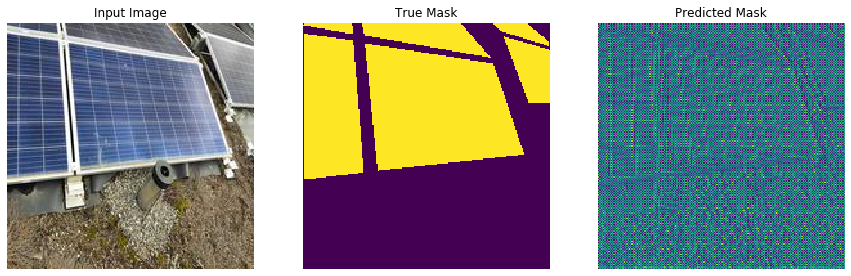

In [20]:
show_predictions(model)

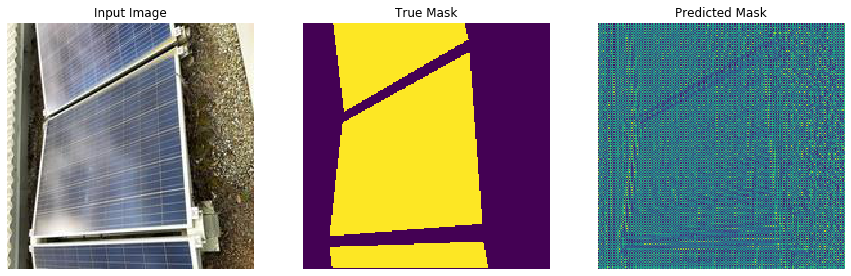

In [21]:
show_predictions(model, gen_train, 1)

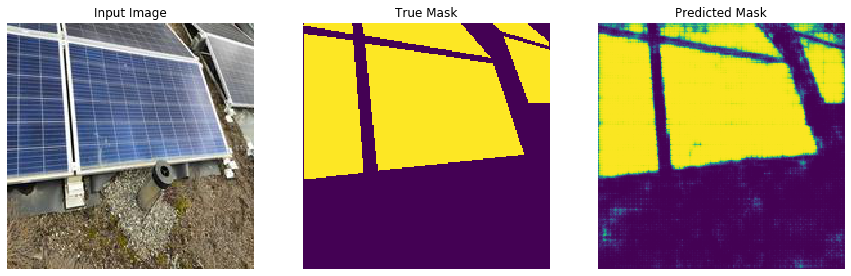


Sample Prediction after epoch 1

--- 56.55337882041931 seconds ---


In [22]:
training_start_time = time()
model_history = model.fit(gen_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=gen_val,
                          callbacks=[DisplayCallback()]
                         )
training_time = time() - training_start_time
log.log_task_end('segmentation_time', training_start_time)
print("--- %s seconds ---" % (training_time))

In [23]:
model_history.history.keys()


dict_keys(['loss', 'accuracy', 'mean_io_u', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_mean_io_u', 'val_recall', 'val_precision'])

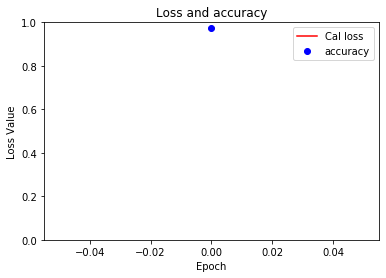

In [24]:
loss = model_history.history['val_loss']
accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Cal loss')
plt.plot(epochs, accuracy, 'bo', label='accuracy')
plt.title('Loss and accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [25]:
model_history.history['val_accuracy'][-1:]

[0.9720391035079956]

In [26]:
#model_history.history['val_accuracy']

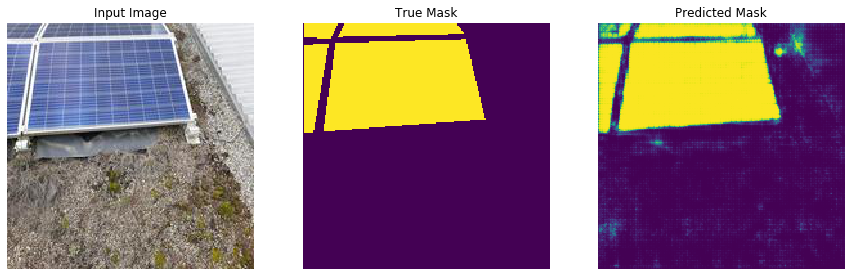

In [27]:
show_predictions(model, gen_train, 1)

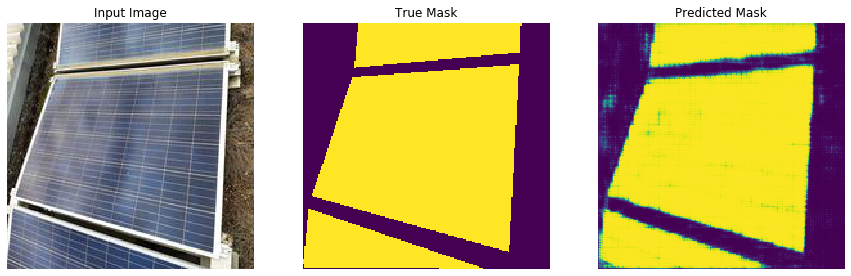

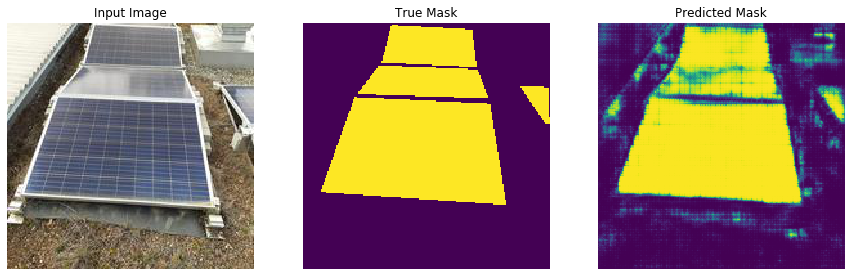

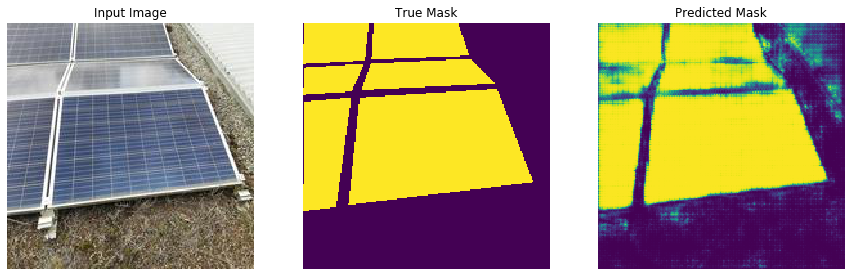

In [28]:
show_predictions(model, gen_val, 3)

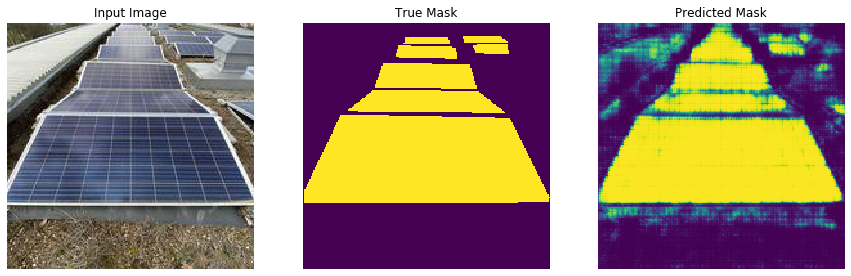

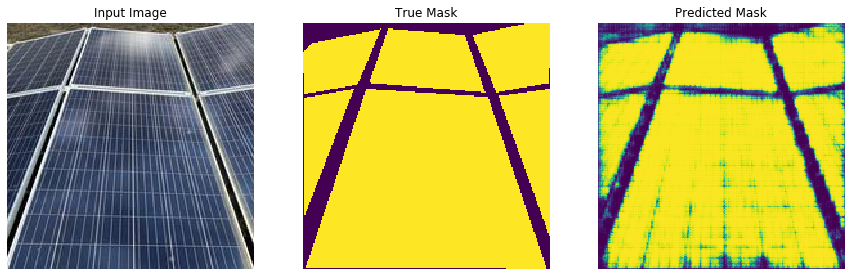

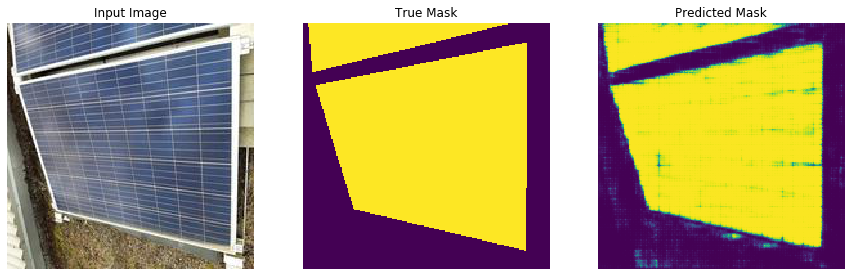

In [29]:
show_predictions(model, gen_test, 3)

## Evaluate Bildsegmentierung

In [30]:
val_dice, val_jaccard = calc_predictions(model, gen_val, 50)

NameError: name 'sample_mask' is not defined

In [ ]:
test_dice, test_jaccard = calc_predictions(model, gen_test, 33)

In [ ]:
test_loss, test_accuracy, test_mean_io_u, test_recall, test_precision = model.evaluate(gen_test, batch_size=batch_size, steps=33)

In [ ]:
# Print Model Summary:
print("MODEL SUMMARY")
print("-------------")
print("Training Accuracy:", model_history.history['accuracy'][-1:][0])
print("Validation Accuracy:", model_history.history['val_accuracy'][-1:][0])
print("Test Accuracy:", test_accuracy)
print("-------------")
print("Training Loss:", model_history.history['loss'][-1:][0])
print("Validation Loss:", model_history.history['val_loss'][-1:][0])
print("Training mean_io_u:", model_history.history['mean_io_u'][-1:][0])
print("Validation mean_io_u:", model_history.history['mean_io_u'][-1:][0])
print("-------------")
print("Validation Dice:", np.mean(val_dice))
print("Validation Jaccard:", np.mean(val_jaccard))
print("Test Dice:", np.mean(test_dice))
print("Test Jaccard:", np.mean(test_jaccard))



In [ ]:
# add Metric to the log
log.add_metric('Training Accuracy', model_history.history['accuracy'][-1:][0])
log.add_metric('Validation Accuracy', model_history.history['val_accuracy'][-1:][0])
log.add_metric('Test Accuracy', test_accuracy)
log.add_metric('Training Loss', model_history.history['loss'][-1:][0])
log.add_metric('Validation Loss', model_history.history['val_loss'][-1:][0])
log.add_metric('Test Loss', test_loss)
log.add_metric('Training  mean_io_u', model_history.history['mean_io_u'][-1:][0])
log.add_metric('Validation mean_io_u', model_history.history['val_mean_io_u'][-1:][0])
log.add_metric('Test mean_io_u', test_mean_io_u)
log.add_metric('Training Recall', model_history.history['recall'][-1:][0])
log.add_metric('Validation Recall', model_history.history['val_recall'][-1:][0])
log.add_metric('Test Recall', test_recall)
log.add_metric('Training  Precision', model_history.history['precision'][-1:][0])
log.add_metric('Validation Precision', model_history.history['val_precision'][-1:][0])
log.add_metric('Test Precision', test_precision)
log.add_metric('Validation Dice', np.mean(val_dice))
log.add_metric('Validation Jaccard', np.mean(val_jaccard))
log.add_metric('Test Dice', np.mean(test_dice))
log.add_metric('Test Jaccard', np.mean(test_jaccard))




# Store, Registration and Recification

In [ ]:
predict_and_store(model, 'test', 'Rathausen_192x192', images_test, dataset_size_test, folder, x, y )

In [ ]:
training_start_time = time()
#predict_and_store('test', 'DeepSolarEye_192x192', images_deepsolareye, dataset_size_deepsolareye, folder_deepsolareye, x, y)
training_time = time() - training_start_time
log.log_task_end('predict_deepsolareye_time', training_start_time)
print("--- %s seconds ---" % (training_time))

# Regression

In [ ]:
# Make Regression on recification deep solar eye pictures
folder = "../data/test/DeepSolarEye_192x192_rec"

In [ ]:
training_start_time = time()
metrics = train_keras(model_name, folder, nr_images_batch, nr_batch, nr_epoch, 10)
training_time = time() - training_start_time
log.log_task_end('regression_time', training_start_time)
print("--- %s seconds ---" % (training_time))

## Evaluate Regression

In [ ]:
# Print Model Summary:
print("MODEL SUMMARY")
print("-------------")
print("Test MSE:", metrics[1])
print("Test RMSE:", metrics[2])
print("Test MAE:", metrics[3])


In [ ]:
# add Metric to the log
log.add_metric('Regression MSE', metrics[1])
log.add_metric('Regression RMSE', metrics[2])
log.add_metric('Regression MAE', metrics[3])

# End of Experiment

In [ ]:
log.log_experiment_end()